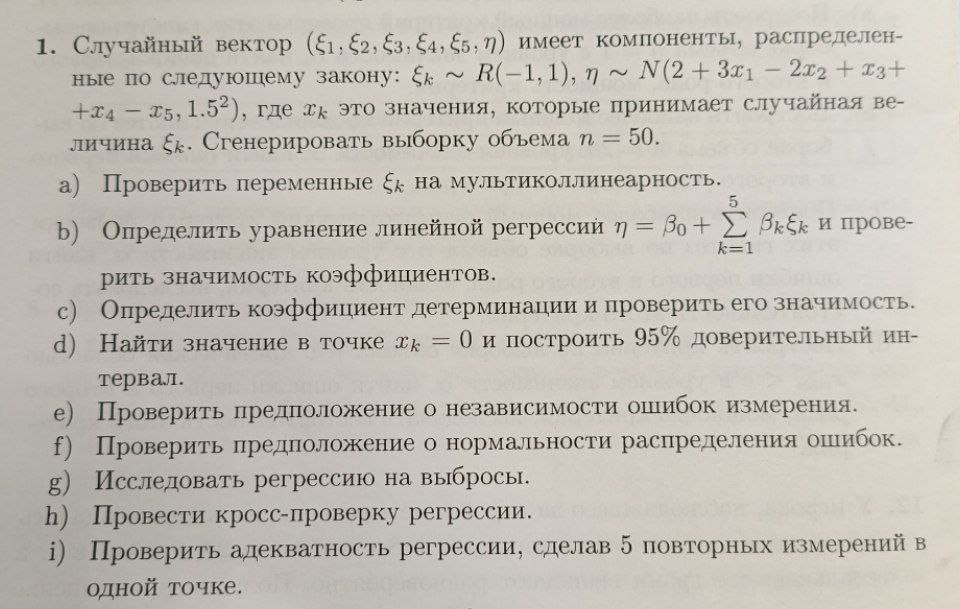

In [609]:
from IPython.display import Image

Image("images/task_1_1.jpg")

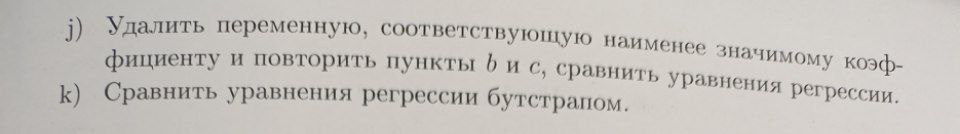

In [610]:
Image("images/task_1_2.jpg")

In [611]:
import numpy as np
import pandas as pd
import random
from numpy import linalg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import t, f, norm
import bisect
from statsmodels.stats.diagnostic import lilliefors
import matplotlib.pyplot as plt


np.random.seed(62)

class Vect:
    k: np.ndarray
    n: int

    def __init__(self):
        self.k = np.array([ np.random.uniform(-1, 1) for i in range(5)])
        self.n = np.random.normal(2 + 3*self.k[0] - 2*self.k[1] + self.k[2] + self.k[3] - self.k[4], 1.5)

    def __getitem__(self, i: int):
        if i < 0 or i > 5:
            raise RuntimeError("Wrong index")
        if i == 5:
            return self.n
        return self.k[i]
    
    def __str__(self):
        return str(self.k) + str(n)
    
    def get_dict(self):
        return {"x1": [self[0]], "x2": [self[1]], "x3": [self[2]], "x4": [self[3]], "x5": [self[4]], "eta": [self[5]]}
    
    def getDataFrame(self):
        return pd.DataFrame(self.get_dict())

n = 50
alpha = 0.05
sample = [ Vect() for i in range(n)]
table = pd.DataFrame(columns=["x1", "x2", "x3", "x4", "x5", "eta"])
for V in sample:
    table = pd.concat([table, V.getDataFrame()], ignore_index=True)
table.T

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
x1,-0.932491,-0.543637,0.992252,-0.193820,-0.964847,-0.458166,0.035259,-0.328689,0.359466,-0.624501,...,-0.613114,-0.374380,-0.594270,-0.017614,0.563125,0.502389,0.530272,0.336242,-0.748148,-0.417386
x2,-0.021785,-0.519447,0.470389,-0.686168,-0.066280,0.469746,-0.228277,0.859822,-0.964333,0.520379,...,0.860806,0.079554,0.121244,-0.426557,-0.461645,-0.691384,-0.099298,-0.254448,0.178916,-0.623895
x3,0.692170,0.906915,0.443885,0.174898,0.820133,-0.622036,-0.536143,0.548006,0.600105,0.084059,...,-0.087898,0.796289,0.270688,-0.755262,-0.325535,-0.683765,-0.230844,0.783042,-0.496683,0.172671
x4,-0.177196,0.291621,-0.179007,-0.230954,-0.794960,-0.435251,0.612482,0.181671,0.328119,0.735645,...,0.494011,0.578985,-0.615684,0.016501,0.865297,0.681671,0.479003,-0.174278,0.692802,-0.430622
x5,0.262831,-0.964286,-0.592440,-0.412192,-0.142773,-0.417066,0.415366,0.775250,-0.402169,-0.661860,...,-0.426039,0.430799,-0.813638,0.570246,-0.181896,0.045939,-0.412915,0.959367,0.286828,0.819967
eta,0.053472,0.858800,5.060287,3.185227,-0.319909,0.031359,1.640353,0.746230,4.241226,0.754355,...,0.170583,0.876192,1.330056,0.000430,4.299854,2.132726,6.134483,2.698809,-0.304265,1.627468


***a)***

In [612]:
Y = np.array(table.T.iloc[5]).reshape(-1, 1)  # Форма (n, 1)
n = Y.shape[0]
TSS = np.sum((Y - np.mean(Y))**2)

psi = np.column_stack([
    np.ones(n), 
    *[np.array(table.T.iloc[j]) for j in range(5)]
])

F = psi.T @ psi

beta_s = np.linalg.lstsq(psi, Y, rcond=None)[0]
e = Y - psi @ beta_s
RSS = (e.T @ e).item()
R2 = (TSS - RSS) / TSS
print(f"\nОбщая R² = {R2:.4f}")

# Анализ мультиколлинеарности через исключение признаков
print("\nАнализ влияния признаков:")

coeff_meaning = []
for i in range(1, 6):  # Перебираем признаки (индексы 1-5 в psi)
    # Удаляем i-й признак
    psi_loc = np.delete(psi, i, axis=1)
    
    # Обучение сокращенной модели
    beta_red = np.linalg.lstsq(psi_loc, Y, rcond=None)[0]
    e_loc = Y - psi_loc @ beta_red
    RSS_loc = (e_loc.T @ e_loc).item()
    R2_loc = (TSS - RSS_loc) / TSS
    
    # Разница в R²
    delta_R2 = R2 - R2_loc
    coeff_meaning.append(delta_R2)
    print(
        f"Без x{i}: R² = {R2_loc:.4f}, "
        f"ΔR² = {delta_R2:.4f}, "
        f"Влияние: {'высокое' if delta_R2 > 0.1 else 'низкое'}"
    )
coeff_meaning = np.array(coeff_meaning)

# Дополнительно: расчет VIF для каждого признака
print("\nVIF анализ:")
vifs = [variance_inflation_factor(psi, i) for i in range(psi.shape[1]-1)]

for i, vif in enumerate(vifs):
    print(f"x{i+1}: VIF = {(vif):.2f}")


Общая R² = 0.7437

Анализ влияния признаков:
Без x1: R² = 0.3031, ΔR² = 0.4406, Влияние: высокое
Без x2: R² = 0.7004, ΔR² = 0.0433, Влияние: низкое
Без x3: R² = 0.7136, ΔR² = 0.0301, Влияние: низкое
Без x4: R² = 0.7219, ΔR² = 0.0218, Влияние: низкое
Без x5: R² = 0.6997, ΔR² = 0.0440, Влияние: низкое

VIF анализ:
x1: VIF = 1.19
x2: VIF = 1.23
x3: VIF = 1.16
x4: VIF = 1.15
x5: VIF = 1.07


In [613]:
basis = ["const", *[ "x" + str(i) for i in range(1, beta_s.shape[0])]]
print(*basis)

const x1 x2 x3 x4 x5


***b)***

In [614]:
print(f"y = {beta_s[0, 0]:.2f} + {beta_s[1, 0]:.2f}*x1 {beta_s[2, 0]:.2f}*x2 + {beta_s[3, 0]:.2f}*x3 + {beta_s[4, 0]:.2f}*x4 {beta_s[5, 0]:.2f}*x5")

p = len(basis)

dt_2 = pd.DataFrame(index=basis, columns=["delta", "p-value", "Вердикт"])
print(f"\n{RSS=:.2f}\n{TSS=:.2f}")

for i in range(p):
    
    delta_s = beta_s[i, 0] * np.sqrt(n - p) / np.sqrt( RSS * linalg.inv(F)[i, i] )
    p_val = 2 * t.cdf(-abs(delta_s), n - p)
    dt_2.loc[basis[i]] = [delta_s, p_val, "значим" if p_val < alpha else "не значим"]
    # print(basis[i], ": delta = ", delta_s, " p-value = ", p_val)

dt_2

y = 2.22 + 3.01*x1 -0.96*x2 + 0.81*x3 + 0.71*x4 -0.88*x5

RSS=74.76
TSS=291.67


,delta,p-value,Вердикт
const,11.062169,0.0,значим
x1,8.697151,0.0,значим
x2,-2.72546,0.009181,значим
x3,2.274372,0.027874,значим
x4,1.933369,0.059641,не значим
x5,-2.749098,0.008636,значим


***c)***

In [615]:
delta = (TSS - RSS) / (p - 1) / ( RSS / (n - p) )
p_val = 1 - f.cdf(delta, p - 1, n - p)
print(f"R2 = {R2:.2f}\ndelta = {delta:.2f}\np-value = {p_val:.6}")
print("Коэффициент значим" if p_val < alpha else "Нет основания говорить что коэффициент значим")

R2 = 0.74
delta = 25.53
p-value = 5.43776e-12
Коэффициент значим


***d)***

In [616]:
const = beta_s[0, 0]

psi_0 = np.array([1, 0, 0, 0, 0, 0])
delta = t.ppf(1 - alpha/2, n - p) * np.sqrt(1 + psi_0 @ linalg.inv(F) @ psi_0.T) * np.sqrt(RSS/(n - p))
print(f'Доверительный интервал: ({const - delta:.2f}, {const + delta:.2f})')

Доверительный интервал: (-0.43, 4.88)


***e)***

In [617]:
count = 0
sorted_list = []
for i, x in enumerate(e):
    pos = bisect.bisect_left(sorted_list, x)
    count += i - pos
    bisect.insort_left(sorted_list, x)
delta = (count - n * (n - 1) / 4) / np.sqrt(n ** 3 / 36)
print(f"Дельта: {delta:.4f}")
p_value = 2 * (1 - norm.cdf(abs(delta), 0, 1))
print(f"p-value = {p_value:.4f}")
print("e зависимы" if p_value < alpha else "Нет основания говорить что e зависимы")

Дельта: -0.7382
p-value = 0.4604
Нет основания говорить что e зависимы


***f)***

In [618]:
delta, p_value = lilliefors(e)
print(f'Дельта = {delta:.4f}')
print(f'p-value = {p_value:.4f}')
print("e ненормально распределены" if p_value < alpha else "Нет основания говорить что e распределены ненормально")

Дельта = 0.0606
p-value = 0.9196
Нет основания говорить что e распределены ненормально


***g)***

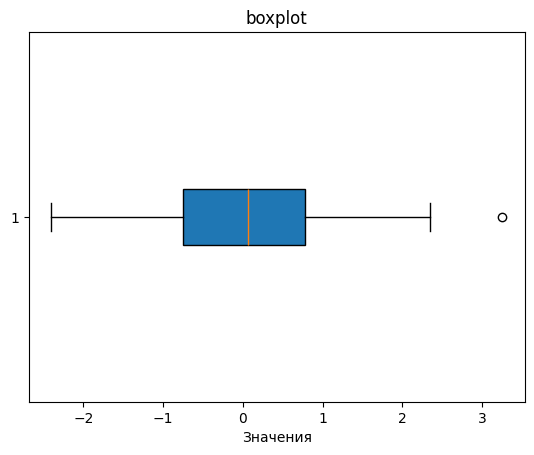

In [619]:
fig, ax = plt.subplots()
ax.boxplot(e, vert=False, patch_artist=True, showfliers=True)
ax.set_title("boxplot")
ax.set_xlabel("Значения")
plt.show()

In [620]:
def prediction(v: Vect, beta):
    return beta[0, 0] + np.sum([ beta[i, 0] * v[i-1] for i in range(1, p) ])
    # return beta_s[0, 0] + beta_s[1, 0] * v[0] + beta_s[2, 0] * v[1] + beta_s[3, 0] * v[2] + beta_s[4, 0] * v[3] + beta_s[1, 0] * v[4]

d = pd.DataFrame(data=[Y[..., 0], [prediction(s, beta_s) for s in sample ]], index=["Y", "prediction"])
d

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Y,0.053472,0.858800,5.060287,3.185227,-0.319909,0.031359,1.640353,0.746230,4.241226,0.754355,...,0.170583,0.876192,1.330056,0.000430,4.299854,2.132726,6.134483,2.698809,-0.304265,1.627468
prediction,-0.366190,2.872207,5.516793,2.636785,-0.398999,-0.050609,2.184210,0.295733,5.302256,1.017687,...,0.207309,1.692095,0.814828,1.477559,4.875485,4.291822,4.435155,3.140766,-0.364370,0.671800


***h)***

In [621]:
CVSS = []
for i in range(n):

    table_loc = table.drop(i)
    Y_loc = np.array(table_loc.T.iloc[5]).reshape(-1, 1)
    n_loc = Y_loc.shape[0]
    TSS = np.sum((Y_loc - np.mean(Y_loc))**2)

    psi_loc = np.column_stack([
        np.ones(n_loc), 
        *[np.array(table_loc.T.iloc[j]) for j in range(5)]
    ])

    beta_loc = np.linalg.lstsq(psi_loc, Y_loc, rcond=None)[0]
    CVSS.append( (Y[i, 0] - prediction(sample[i], beta_loc))**2 )
CVSS = np.sum(CVSS)
R_cv = (TSS - CVSS) / TSS
print(f'CVSS = {CVSS:.4f}')
print(f'R^2 для CVSS = {R_cv:.4f}')

CVSS = 97.9844
R^2 для CVSS = 0.6632


***i)***

In [622]:
l = 5
Y_povt = np.random.normal(2, 1.5, l)

sigma_1_2 = 1 / (l - 1) * np.sum( (Y_povt - np.mean(Y_povt))**2  )
delta = RSS / (n - p) / sigma_1_2
p_val = 1 - f.cdf(delta, n - p, l - 1)
print(f'sigma_1_2 = {sigma_1_2:.4f}')
print(f'Дельта: {delta}')
print(f'p-value: {p_val}')
print("Модель неадекватна" if p_value < alpha else "Нет основания говорить что модель неадекватна")

sigma_1_2 = 1.6929
Дельта: 1.003609756365396
p-value: 0.5803514261061041
Нет основания говорить что модель неадекватна


***j)***

In [623]:
max_p = np.min(coeff_meaning)
index = np.where(coeff_meaning == max_p)[0][0] + 1
print("Убираем", basis[index])
basis_corr = [basis[i] for i in range(6) if i != index]
print("Basis:", *basis_corr)


table_corr = table.drop(columns=[basis[index]])

Y_corr = np.array(table_corr.T.iloc[-1]).reshape(-1, 1)
n_corr = Y_corr.shape[0]
TSS_corr = np.sum((Y_corr - np.mean(Y_corr))**2)

psi_corr = np.column_stack([
    np.ones(n_corr), 
    *[np.array(table_corr.T.iloc[j]) for j in range(4)]
])

F_corr = psi_corr.T @ psi_corr

beta_s_corr = np.linalg.lstsq(psi_corr, Y_corr, rcond=None)[0]


e_corr = Y_corr - psi_corr @ beta_s_corr
RSS_corr = (e_corr.T @ e_corr).item()
R2_corr = (TSS_corr - RSS_corr) / TSS_corr

print(f"y = {beta_s_corr[0, 0]:.2f}", *[f"+ {beta_s_corr[i, 0]:.2f}*{basis_corr[i]}" for i in range(1, 5) ])

p_corr = len(basis_corr)
dt_2 = pd.DataFrame(index=basis_corr, columns=["delta", "p-value", "Вердикт"])

for i in range(p_corr):
    
    delta_s = beta_s_corr[i, 0] * np.sqrt(n - p_corr) / np.sqrt( RSS_corr * linalg.inv(F_corr)[i, i] )
    p_val = 2 * t.cdf(-abs(delta_s), n - p_corr)
    dt_2.loc[basis_corr[i]] = [delta_s, p_val, "значим" if p_val < alpha else "не значим"]
dt_2

Убираем x4
Basis: const x1 x2 x3 x5
y = 2.32 + 3.08*x1 + -0.98*x2 + 0.68*x3 + -0.91*x5


,delta,p-value,Вердикт
const,11.6296,0.0,значим
x1,8.671587,0.0,значим
x2,-2.721999,0.009197,значим
x3,1.903302,0.063409,не значим
x5,-2.74257,0.008719,значим


In [624]:
print(f"RSS = {RSS_corr:.4f}\nTSS = {TSS_corr:.4f}")

RSS = 81.1060
TSS = 291.6651


In [625]:
delta = (TSS_corr - RSS_corr) / (p_corr - 1) / ( RSS_corr / (n - p_corr) )
p_val = 1 - f.cdf(delta, p_corr - 1, n - p_corr)
print(f"R2 = {R2_corr:.2f}\ndelta = {delta:.2f}\np-value = {p_val:.6f}")
print("Коэффициент значим" if p_val < alpha else "Нет основания говорить что коэффициент не значим")

R2 = 0.72
delta = 29.21
p-value = 0.000000
Коэффициент значим


***k)***

In [ ]:
n_bootstrap = 1000
R2_delta = R2 - R2_corr
bootstrap_delta = []

for _ in range(n_bootstrap):

    sample_boots = np.random.choice(sample, size=n, replace=True)
    table_boots = pd.DataFrame(columns=["x1", "x2", "x3", "x4", "x5", "eta"])
    for V in sample_boots:
        table_boots = pd.concat([table_boots, V.getDataFrame()], ignore_index=True)
    
    Y_corr = np.array(table_boots.T.iloc[5]).reshape(-1, 1)
    n_corr = Y_corr.shape[0]
    TSS_corr = np.sum((Y_corr - np.mean(Y_corr))**2)

    psi_corr = np.column_stack([
        np.ones(n_corr), 
        *[np.array(table_boots.T.iloc[j]) for j in range(5)]
    ])

    beta_s_corr = np.linalg.lstsq(psi_corr, Y_corr, rcond=None)[0]
    e_corr = Y_corr - psi_corr @ beta_s_corr
    RSS_corr = (e_corr.T @ e_corr).item()
    
    R2_1 = (TSS_corr - RSS_corr) / TSS_corr


    table_boots = table_boots.drop(columns=[basis[index]])

    Y_corr = np.array(table_boots.T.iloc[-1]).reshape(-1, 1)
    n_corr = Y_corr.shape[0]
    TSS_corr = np.sum((Y_corr - np.mean(Y_corr))**2)

    psi_corr = np.column_stack([
        np.ones(n_corr), 
        *[np.array(table_boots.T.iloc[j]) for j in range(4)]
    ])

    beta_s_corr = np.linalg.lstsq(psi_corr, Y_corr, rcond=None)[0]
    e_corr = Y_corr - psi_corr @ beta_s_corr
    RSS_corr = (e_corr.T @ e_corr).item()
    
    R2_2 = (TSS_corr - RSS_corr) / TSS_corr
    bootstrap_delta.append( R2_1 - R2_2 - R2_delta )

bootstrap_delta.sort()
t1 = bootstrap_delta[int(n_bootstrap * (alpha / 2))]
t2 = bootstrap_delta[int(n_bootstrap * ((1 + (1 - alpha)) / 2))]
print(f'Доверительный интервал: ({R2_delta - t2}, {R2_delta - t1})')
print("Нет основания отвергать H_0" if (R2_delta - t2 < 0 < R2_delta - t1) else "Отвергаем H_0")

Доверительный интервал: (-0.03313947407606577, 0.043222191011105915)
Нет основания отвергать H_0
